<div style="text-align: center; font-size:300%"> Title </div>
<br>
<div style="text-align: center; font-size:200%"> CMSC 320 </div>
<br>
<div style="text-align: center; font-size:200%"> Michael Suehle and Nathan Valencia </div>

# Introduction

# Data Collection
Here we scrape the website for the table we need. We do this easily using code from project 1.

In [24]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from IPython.core.display import HTML,display

val_request = requests.get('https://www.vlr.gg/stats/?event_group_id=all&event_id=926&series_id=all&region=all&country=all&min_rounds=1&min_rating=0&agent=all&map_id=all&timespan=90d') 

root = BeautifulSoup(val_request.content, 'html.parser')
table = root.find('table')

Note that the agents are not read in. We should do something about that
also note that clutch percentage has missing data where it should be 0, so we will will that in too

In [25]:
val_data = pd.read_html(str(table))[0]
val_data.tail()

,Player,Agents,Rnd,ACS,K:D,KAST,ADR,KPR,APR,FKPR,FDPR,HS%,CL%,CL,KMax,K,D,A,FK,FD
55,FNS OPTC,(+2),468,162.3,0.81,68%,109.0,0.56,0.25,0.07,0.06,21%,13%,6/48,21,261,323,116,33,26
56,bnj NIP,NaN,147,159.9,0.86,68%,108.8,0.56,0.25,0.05,0.07,25%,29%,8/28,19,82,95,37,8,10
57,mindfreak PRX,NaN,209,158.4,0.79,70%,101.6,0.56,0.38,0.03,0.05,26%,16%,4/25,17,116,147,80,7,11
58,Meddo G2,NaN,128,152.8,0.76,64%,97.6,0.54,0.12,0.02,0.08,27%,5%,1/22,20,69,91,15,3,10
59,Boaster FNC,NaN,85,133.8,0.54,62%,88.1,0.44,0.32,0.04,0.12,17%,NaN,0/11,12,37,69,27,3,10


In [26]:
#change NaN in CL% to 0
val_data['CL%'] = val_data['CL%'].replace(np.nan, 0)

#lets get those agents
agent_table = table.findAll('td','mod-agents')
agents_col = []

for row in agent_table:
    agents = []

    for img in row.findAll('img'):
        agents.append('<img src="https://www.vlr.gg'+img['src']+'" width="30" >')
    
    agents_col.append(agents)

val_data['agent_img_tags'] = agents_col
display(HTML(val_data.head().to_html(escape=False)))

,Player,Agents,Rnd,ACS,K:D,KAST,ADR,KPR,APR,FKPR,FDPR,HS%,CL%,CL,KMax,K,D,A,FK,FD,agent_img_tags
0,ScreaM TL,NaN,243,260.5,1.22,75%,164.6,0.86,0.31,0.16,0.08,33%,16%,3/19,24,210,172,75,39,20,"[, , ]"
1,yay OPTC,NaN,468,252.3,1.32,73%,158.4,0.89,0.15,0.17,0.14,26%,11%,5/45,30,417,317,69,78,66,"[, ]"
2,Sayaplayer TGRD,NaN,108,251.0,1.27,69%,156.9,0.88,0.14,0.19,0.18,27%,0,0/15,27,95,75,15,20,19,"[, ]"
3,Jinggg PRX,(+1),209,250.6,1.10,67%,166.6,0.88,0.24,0.12,0.14,16%,14%,1/7,28,184,168,51,25,30,"[, , ]"
4,aspas LLL,NaN,240,249.3,1.26,76%,153.0,0.88,0.15,0.14,0.16,26%,13%,3/23,29,211,168,35,34,39,"[, ]"


### Data Wrangling
Here we add the names of the agents along with their classes.

Below I am going to fill the Agents column with names of the agents

In [27]:
import re
import math

new_agents = []
for i, row in val_data.iterrows():
    agent_names = []
    img_tags = row['agent_img_tags']
    for tag in img_tags:
        match = re.search(r'<img src="https:\/\/www\.vlr\.gg\/img\/vlr\/game\/agents\/([A-Za-z]+)\.png" width="30" >', tag)
        agent_names.append(match.group(1))
        
    if isinstance(row['Agents'], str):
        agent_names.append(row['Agents'])
        
    new_agents.append(agent_names)

val_data.drop('Agents', axis=1)
val_data['Agents'] = new_agents
display(HTML(val_data.head().to_html(escape=False))) #in final proj, we should print the table as little as possible but this is here for testing

,Player,Agents,Rnd,ACS,K:D,KAST,ADR,KPR,APR,FKPR,FDPR,HS%,CL%,CL,KMax,K,D,A,FK,FD,agent_img_tags
0,ScreaM TL,"[jett, kayo, sage]",243,260.5,1.22,75%,164.6,0.86,0.31,0.16,0.08,33%,16%,3/19,24,210,172,75,39,20,"[, , ]"
1,yay OPTC,"[chamber, jett]",468,252.3,1.32,73%,158.4,0.89,0.15,0.17,0.14,26%,11%,5/45,30,417,317,69,78,66,"[, ]"
2,Sayaplayer TGRD,"[jett, raze]",108,251.0,1.27,69%,156.9,0.88,0.14,0.19,0.18,27%,0,0/15,27,95,75,15,20,19,"[, ]"
3,Jinggg PRX,"[reyna, raze, kayo, (+1)]",209,250.6,1.10,67%,166.6,0.88,0.24,0.12,0.14,16%,14%,1/7,28,184,168,51,25,30,"[, , ]"
4,aspas LLL,"[jett, raze]",240,249.3,1.26,76%,153.0,0.88,0.15,0.14,0.16,26%,13%,3/23,29,211,168,35,34,39,"[, ]"


Now I map the agents to their classes and add a column for that

In [28]:
classes = {'phoenix':'duelist',
           'jett':'duelist',
           'viper':'controller',
           'sova':'initiator',
           'cypher':'sentinel',
           'brimstone':'controller',
           'sage':'sentinel',
           'omen':'controller',
           'raze':'duelist',
           'breach':'initiator',
           'astra':'controller',
           'chamber':'sentinel',
           'kayo':'initiator',
           'killjoy':'sentinel',
           'neon':'duelist',
           'reyna':'duelist',
           'skye':'initiator',
           'yoru':'duelist'}

class_names_column = []
for i, row in val_data.iterrows():
    class_names = []
    
    for name in row['Agents']:
        if name in classes.keys():
            class_names.append(classes[name])
            
    class_names_column.append(class_names)
    
val_data['classes'] = class_names_column
val_data.head()

,Player,Agents,Rnd,ACS,K:D,KAST,ADR,KPR,APR,FKPR,...,CL%,CL,KMax,K,D,A,FK,FD,agent_img_tags,classes
0,ScreaM TL,"[jett, kayo, sage]",243,260.5,1.22,75%,164.6,0.86,0.31,0.16,...,16%,3/19,24,210,172,75,39,20,"[<img src=""https://www.vlr.gg/img/vlr/game/age...","[duelist, initiator, sentinel]"
1,yay OPTC,"[chamber, jett]",468,252.3,1.32,73%,158.4,0.89,0.15,0.17,...,11%,5/45,30,417,317,69,78,66,"[<img src=""https://www.vlr.gg/img/vlr/game/age...","[sentinel, duelist]"
2,Sayaplayer TGRD,"[jett, raze]",108,251.0,1.27,69%,156.9,0.88,0.14,0.19,...,0,0/15,27,95,75,15,20,19,"[<img src=""https://www.vlr.gg/img/vlr/game/age...","[duelist, duelist]"
3,Jinggg PRX,"[reyna, raze, kayo, (+1)]",209,250.6,1.10,67%,166.6,0.88,0.24,0.12,...,14%,1/7,28,184,168,51,25,30,"[<img src=""https://www.vlr.gg/img/vlr/game/age...","[duelist, duelist, initiator]"
4,aspas LLL,"[jett, raze]",240,249.3,1.26,76%,153.0,0.88,0.15,0.14,...,13%,3/23,29,211,168,35,34,39,"[<img src=""https://www.vlr.gg/img/vlr/game/age...","[duelist, duelist]"


# Data Processing
Imma plot da frequency of the classes

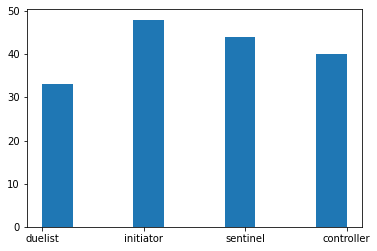

In [29]:
import matplotlib.pyplot as plt
all_classes = []

for class_list in val_data['classes']:
    all_classes = all_classes + class_list

plt.hist(all_classes)
plt.show()

Imma plot the frequency of characters now by doing similar thing

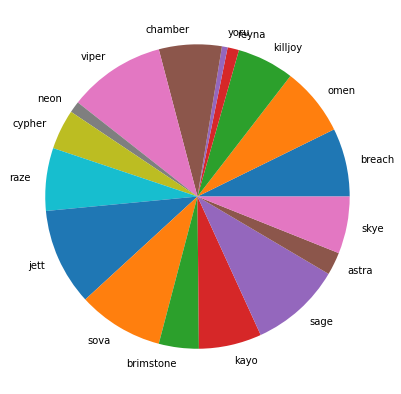

In [45]:
all_agents = []

for agent_list in val_data['Agents']:
    all_agents = all_agents + agent_list

for i in range(all_agents.count('(+2)')):
    all_agents.remove('(+2)')

for i in range(all_agents.count('(+1)')):
    all_agents.remove('(+1)')

counts = {i:all_agents.count(i) for i in set(all_agents)}

fig = plt.figure(figsize =(10, 7))
plt.pie(counts.values(), labels=counts.keys(), normalize=True)
plt.show()

Imma plot kills per round and average damage per round cuz i think they have a linear relationship

                            OLS Regression Results                            
Dep. Variable:                    KPR   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     337.6
Date:                Wed, 04 May 2022   Prob (F-statistic):           7.45e-26
Time:                        02:06:27   Log-Likelihood:                 109.26
No. Observations:                  60   AIC:                            -214.5
Df Residuals:                      58   BIC:                            -210.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0220      0.039     -0.558      0.5

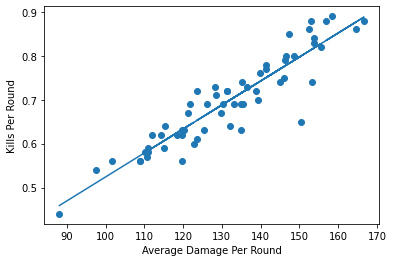

In [18]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

X = val_data['ADR']
y = val_data['KPR']
X2 = sm.add_constant(X)
reg = sm.OLS(y, X2).fit()

print(reg.summary())
plt.plot(X, reg.predict([[1,i] for i in X]))
plt.scatter(val_data['ADR'], val_data['KPR'])
plt.xlabel('Average Damage Per Round')
plt.ylabel('Kills Per Round')
plt.title('Kills Per Round vs Average Damage Per Round')
plt.show()

Things to note: 
p-val is 0 which means this is statistically significant (aka we reject the null hypothesis)
r-square value is .853 indicating a strong correlation

# Analysis

# Insights

# Additional Resources